# Bayesian Neural Networks 

* Adapted from Deep Learning online course notes from NYU. [Note link](https://atcold.github.io/pytorch-Deep-Learning/en/week14/14-3/)
* [Paper about using Dropout as a Bayesian Approximation](https://arxiv.org/pdf/1506.02142.pdf)

Another notebook which uses PyTorch dropout: [Link](https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/)

In addition to predicting a value from a model it is also important to know the confidence in that prediction. Dropout is one way of estimating this. After multiple rounds of predictions, the mean and standard deviation in the prediction can be viewed as the prediction value and the corresponding confidence in the prediction. It is important to note that this is different from the error in the prediction. The model may have error in the prediction but could be precise in that value. It is similar to the idea of accuracy vs precision. 

When done with dropout -- the weights in the NN are scale by $\frac{1}{1-r}$ to account for dropping of the weights 

In [43]:
import torch 
from torch import nn, optim
import numpy as np 

In [44]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%config InlineBackend.figure_format = 'retina'
 
plot_params = {
'font.size' : 22,
'axes.titlesize' : 24,
'axes.labelsize' : 20,
'axes.labelweight' : 'bold',
'lines.linewidth' : 3,
'lines.markersize' : 10,
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,
}
 
plt.rcParams.update(plot_params)

In [59]:
# Training set
m = 50
x = (torch.rand(m) - 0.5) * 20
y = x * torch.sin(x) 

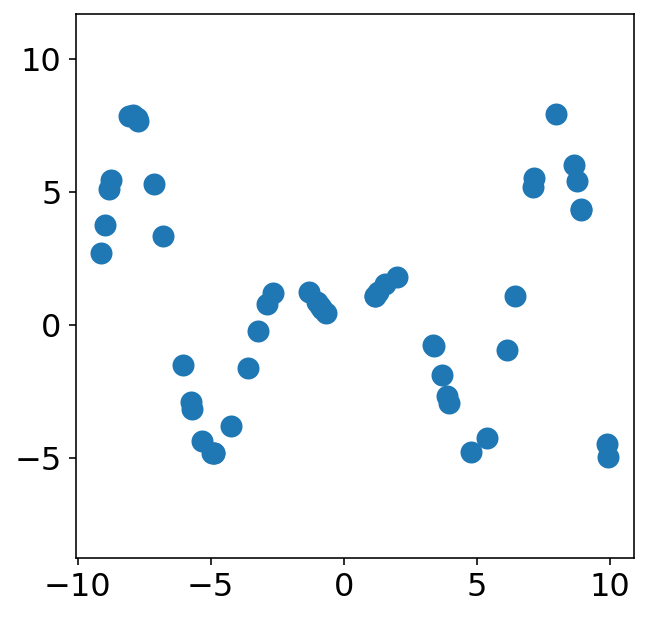

In [60]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(x.numpy(), y.numpy(), 'o')
ax.axis('equal');

In [61]:
# Define a simple NN 
class MLP(nn.Module):
    def __init__(self, hidden_layers=[20, 20], droprate=0.2, activation='relu'):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        self.model.add_module('input', nn.Linear(1, hidden_layers[0]))
        
        if activation == 'relu':
            self.model.add_module('relu0', nn.ReLU())
        
        elif activation == 'tanh':
            self.model.add_module('tanh0', nn.Tanh())
            
        for i in range(len(hidden_layers)-1):
            self.model.add_module('dropout'+str(i+1), nn.Dropout(p=droprate))
            self.model.add_module('hidden'+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            
            if activation == 'relu':
                self.model.add_module('relu'+str(i+1), nn.ReLU())
                
            elif activation == 'tanh':
                self.model.add_module('tanh'+str(i+1), nn.Tanh())
                
        self.model.add_module('dropout'+str(i+2), nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(hidden_layers[i+1], 1))
        
    def forward(self, x):
        return self.model(x)

In [62]:
# Define the model 
net = MLP(hidden_layers=[100, 80], droprate=0.05)
print(net)

MLP(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=100, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.05, inplace=False)
    (hidden1): Linear(in_features=100, out_features=80, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.05, inplace=False)
    (final): Linear(in_features=80, out_features=1, bias=True)
  )
)


In [63]:
# Objective and optimizer 
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay=0.00001)

In [64]:
# Training loop 
for epoch in range(6000):
    y_hat = net(x.view(-1, 1))
    loss = criterion(y_hat, y.view(-1, 1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print('Epoch[{}] - Loss:{}'.format(epoch, loss.item()))

Epoch[0] - Loss:14.531793594360352
Epoch[500] - Loss:2.970477342605591
Epoch[1000] - Loss:0.8234246969223022
Epoch[1500] - Loss:1.1125026941299438
Epoch[2000] - Loss:0.5566067695617676
Epoch[2500] - Loss:0.2671222984790802
Epoch[3000] - Loss:0.24521812796592712
Epoch[3500] - Loss:0.5118185877799988
Epoch[4000] - Loss:0.386966347694397
Epoch[4500] - Loss:0.28896209597587585
Epoch[5000] - Loss:0.24640348553657532
Epoch[5500] - Loss:0.26505449414253235


In [65]:
XX = torch.linspace(-15, 15, 1000)

In [66]:
def predict_reg(model, X, T=1000):
    
    model = model.train()
    Y_hat = list()
    with torch.no_grad():
        for t in range(T):
            Y_hat.append(model(X.view(-1,1)).squeeze())
    Y_hat = torch.stack(Y_hat)
    
    model = model.eval()
    with torch.no_grad():
        Y_eval = model(X.view(-1,1)).squeeze()

    return Y_hat, Y_eval

In [67]:
y_hat, y_eval = predict_reg(net, XX, T=100)
mean_y_hat = y_hat.mean(axis=0)
std_y_hat = y_hat.std(axis=0)

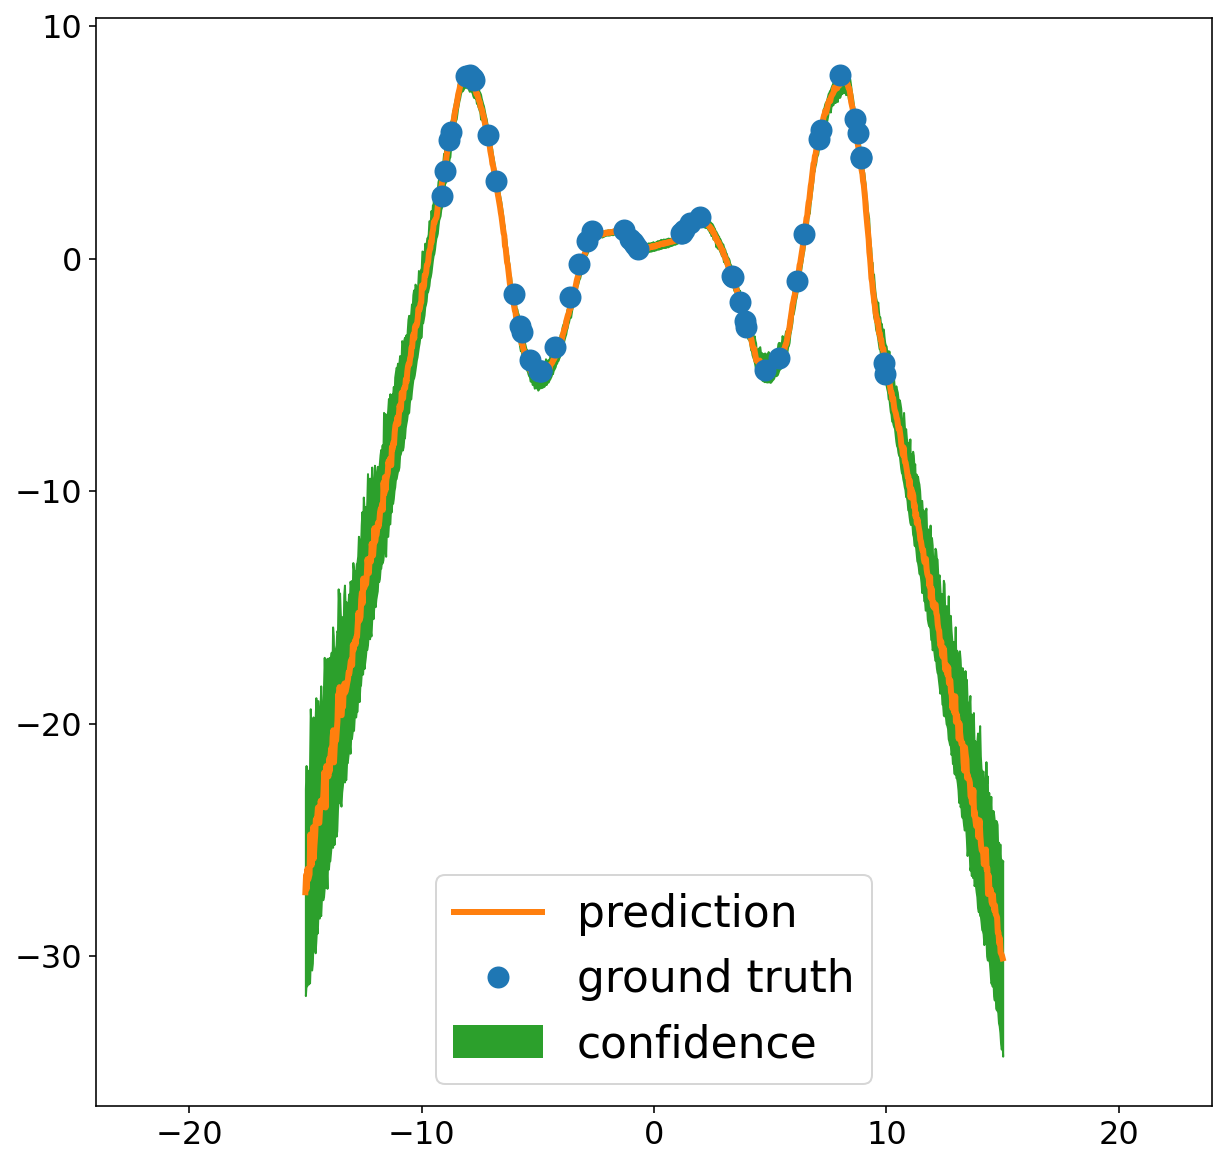

In [68]:
# Visualise mean and mean ± std -> confidence range
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(XX.numpy(), mean_y_hat.numpy(), 'C1', label='prediction')
ax.fill_between(XX.numpy(), (mean_y_hat + std_y_hat).numpy(), (mean_y_hat - std_y_hat).numpy(), color='C2', label='confidence')
ax.plot(x.numpy(), y.numpy(), 'oC0', label='ground truth')
ax.axis('equal')
plt.legend()